In [1]:
import os
import re
import operator
import matplotlib.pyplot as plt
import warnings
import gensim
import numpy as np
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.corpora import Dictionary
from pprint import pprint

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline

In [2]:
from gensim.utils import lemmatize
from nltk.corpus import stopwords

#### LDA Training

In [3]:
def build_texts(fname):
    """
    Function to build tokenized texts from file
    
    Parameters:
    ----------
    fname: File to be read
    
    Returns:
    -------
    yields preprocessed line
    """
    with open(fname) as f:
        for line in f:
            yield gensim.utils.simple_preprocess(line, deacc=True, min_len=3)

In [4]:
stops = set(stopwords.words('english'))  # nltk stopwords list

In [5]:
def process_texts(texts):
    """
    Function to process texts. Following are the steps we take:
    
    1. Stopword Removal.
    # 2. Collocation detection.
    3. Lemmatization (not stem since stemming can reduce the interpretability).
    
    Parameters:
    ----------
    texts: Tokenized texts.
    
    Returns:
    -------
    texts: Pre-processed tokenized texts.
    """
    texts = [[word for word in line if word not in stops] for line in texts]
    # texts = [bigram[line] for line in texts]
    texts = [[word.split('/')[0] for word in lemmatize(' '.join(line), 
                    allowed_tags=re.compile('(NN)'), min_length=3)] for line in texts]
    return texts

In [6]:
train_texts = list(build_texts('consolidated.txt'))

In [7]:
train_texts = process_texts(train_texts)

In [8]:
len(train_texts)

1941

In [9]:
train_texts_sklearn = [" ".join(ls) for ls in train_texts]

### Sklearn

In [10]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = stops,
                                lowercase = True,
                                max_df = 0.5, 
                                min_df = 0.05,
                                ngram_range = (1, 4))
dtm_tf = tf_vectorizer.fit_transform(train_texts_sklearn)
print(dtm_tf.shape)

(1941, 643)


In [11]:
vocabulary_gensim = {}
vocab = Dictionary()
for key, val in tf_vectorizer.vocabulary_.items():
    vocabulary_gensim[val] = key
_ = vocab.merge_with(vocabulary_gensim)   
corpus_vect_gensim = gensim.matutils.Sparse2Corpus(dtm_tf, documents_columns=False)

In [12]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

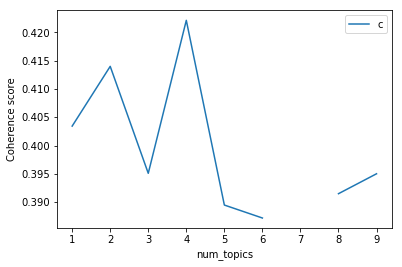

In [13]:
lmlist, c_v = evaluate_graph(dictionary=vocab, corpus=corpus_vect_gensim, texts=train_texts, limit=10)

In [23]:
ldamodel = LdaModel(corpus=corpus_vect_gensim, num_topics=4, id2word=vocab)

In [24]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [25]:
pyLDAvis.gensim.prepare(ldamodel, corpus_vect_gensim, vocab)

/home/hadrian/anaconda3/envs/py27/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      33.194346        1       1  0.012376 -0.001290
0      24.672058        1       2  0.004163 -0.011464
2      23.891168        1       3 -0.020443 -0.000571
3      18.242429        1       4  0.003904  0.013324, topic_info=     Category         Freq               Term        Total  loglift  logprob
term                                                                        
141   Default  2345.000000              blood  2345.000000  30.0000  30.0000
136   Default  3062.000000            product  3062.000000  29.0000  29.0000
175   Default  2147.000000               food  2147.000000  28.0000  28.0000
444   Default  4825.000000               drug  4825.000000  27.0000  27.0000
373   Default  2024.000000            project  2024.000000  26.0000  26.0000
615   Default  1601.000000          treatment  1601.000000  25.0000  25.0000
306   Default  5726.000000                doh  5726.000000  24.0000  24.0000
163   Default  1916.000000          committee  1916.000000  23.0000  23.0000
532   Default  3349.000000               unit  3349.000000  22.0000  22.0000
538   Default  2644.000000            patient  2644.000000  21.0000  21.0000
196   Default  2258.000000         laboratory  2258.000000  20.0000  20.0000
220   Default  3156.000000               care  3156.000000  19.0000  19.0000
265   Default  3179.000000             center  3179.000000  18.0000  18.0000
14    Default  4784.000000            program  4784.000000  17.0000  17.0000
364   Default  2299.000000        requirement  2299.000000  16.0000  16.0000
203   Default   852.000000           research   852.000000  15.0000  15.0000
248   Default  3534.000000             system  3534.000000  14.0000  14.0000
20    Default   453.000000         ingredient   453.000000  13.0000  13.0000
278   Default  2213.000000         philippine  2213.000000  12.0000  12.0000
240   Default  1800.000000            quality  1800.000000  11.0000  11.0000
497   Default  1415.000000        application  1415.000000  10.0000  10.0000
398   Default   958.000000            license   958.000000   9.0000   9.0000
290   Default   623.000000              donor   623.000000   8.0000   8.0000
379   Default   346.000000              label   346.000000   7.0000   7.0000
182   Default   738.000000               bank   738.000000   6.0000   6.0000
184   Default  1060.000000               name  1060.000000   5.0000   5.0000
460   Default  2597.000000        development  2597.000000   4.0000   4.0000
480   Default  2005.000000             person  2005.000000   3.0000   3.0000
518   Default  1405.000000            officer  1405.000000   2.0000   2.0000
92    Default  1102.000000                fee  1102.000000   1.0000   1.0000
...       ...          ...                ...          ...      ...      ...
301    Topic4   334.122350       organization  1317.136790   0.3297  -5.3781
265    Topic4   747.201582             center  3179.512255   0.2533  -4.5733
248    Topic4   811.539150             system  3534.745861   0.2300  -4.4907
14     Topic4  1051.755473            program  4784.795639   0.1864  -4.2314
497    Topic4   348.006695        application  1415.205531   0.2986  -5.3374
480    Topic4   470.658089             person  2005.957008   0.2517  -5.0355
306    Topic4  1187.722148                doh  5726.662876   0.1283  -4.1098
574    Topic4   348.007224            support  1447.491637   0.2761  -5.3374
518    Topic4   338.530501            officer  1405.534847   0.2779  -5.3650
609    Topic4   293.456643  department health  1195.486362   0.2968  -5.5079
532    Topic4   677.969507               unit  3349.451130   0.1040  -4.6705
460    Topic4   539.603242        development  2597.757650   0.1299  -4.8988
222    Topic4   556.191839           training  2724.256112   0.1126  -4.8685
299    Topic4   434.093993               plan  1994.747796   0.1764  -5.1164
243    Topic4 

In [26]:
ldamodel.save('consolidated_lda.bin')
vocab.save('consolidated_corpus.dict')

#### Productionization

In [18]:
lda_model = gensim.models.LdaModel.load('consolidated_lda.bin')

In [19]:
id2word = gensim.corpora.Dictionary.load('consolidated_corpus.dict')

In [20]:
query = 'maternal'.split()

In [21]:
results = sorted(ldamodel[id2word.doc2bow(query)], key=lambda tup: tup[1], reverse=True)

In [22]:
lda_model.print_topic(results[0][0], topn=20)

u'0.014*"system" + 0.014*"doh" + 0.012*"government" + 0.012*"facility" + 0.011*"program" + 0.011*"policy" + 0.010*"activity" + 0.010*"product" + 0.009*"drug" + 0.009*"care" + 0.009*"implementation" + 0.009*"development" + 0.009*"project" + 0.008*"standard" + 0.008*"level" + 0.007*"emergency" + 0.007*"management" + 0.007*"plan" + 0.007*"department" + 0.007*"philippine"'